
# Correlation Strategy Part I - Global 
##### Author 

Jose Miguel Serra Lleti - lleti@embl.de

This notebook corresponds to the article: _CLEMSite, a software for automated phenotypic screens using light microscopy and FIB-SEM._ 

_Please, cite the original paper if you make use of anything present in this notebook._
  
## Description

  In the experimental setup presented in the article, MatTek dishes were used to automatically correlate cells from light microscopy (LM) with electron microscopy (EM). Here is presented the method to achieve that.
  
  The common landmarks used between LM and EM, where the grid crossings, as shown in the figure here, where the orange point between the four crossing marks, is what we define as landmark:
  <img src="images/grid_measures.png" width="600"/>


 The correlation strategy for CLEM is based in detecting landmarks in both LM and SEM. Although very simple conceptually, in practice, the correlation needs several refinements to achieve a good accuracy in landmark detection. The important message is that we can build the same strategy with any sample carrier by identifying geometrical features sparsed homogeneously around the grid over a known distance. 
 <img src="images/mat_1.png" width="800"/>



In this notebook, the MSE (mean square error) between the observed target cell and the center position measured is taken as a measure of accuracy. This accuracy is first calculated between observed and detected landmark positions, and later on, in the second part, using the ground truth position of the cell in the FIB/SEM microscope, as defined by the expert microscopist.
 
 
 ## 1. Building a simple linear model
 
 We start by a simple approach: 
  - We obtain 3 points of the grid to create an orthogonal base, so it can be used as reference base. Using CLEMSite in the SEM, the microscope user can identify $\hat x$ spots manually clicking on their positions or by using the line detector to identify the crossing associated to a square. If the line detector is chosen, then the four corners are automatically identified and the values saved in a folder.  We can find and load the four spot positions saved in the p0_* folder inside the SCAN folder of a CLEMSite project that is used by the Navigator. We obtain 4 pairs of coordinates (we will use x and y and neglect z differences).
  - For starting, 3 initial coordinates are enough to compute a linear model to predict other positions in the same grid. We can use a fictious model that assumes a squared grid that has a space of 10 units between them. Three ideal $x$ grid coordinates could be something like (0,0), (10,0) and (0,10). Then, the corresponding fake coordinates are assigned to their equivalent in stage coordinates. The linear model is solved and can be used to predict any position in the grid. 
   <img src="images/model_1.png" width="400"/>
  
  - This model works nicely in the vicinity of the detected landmarks. However, as we move away from there, the error grows dramatically. 

In [1]:
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>


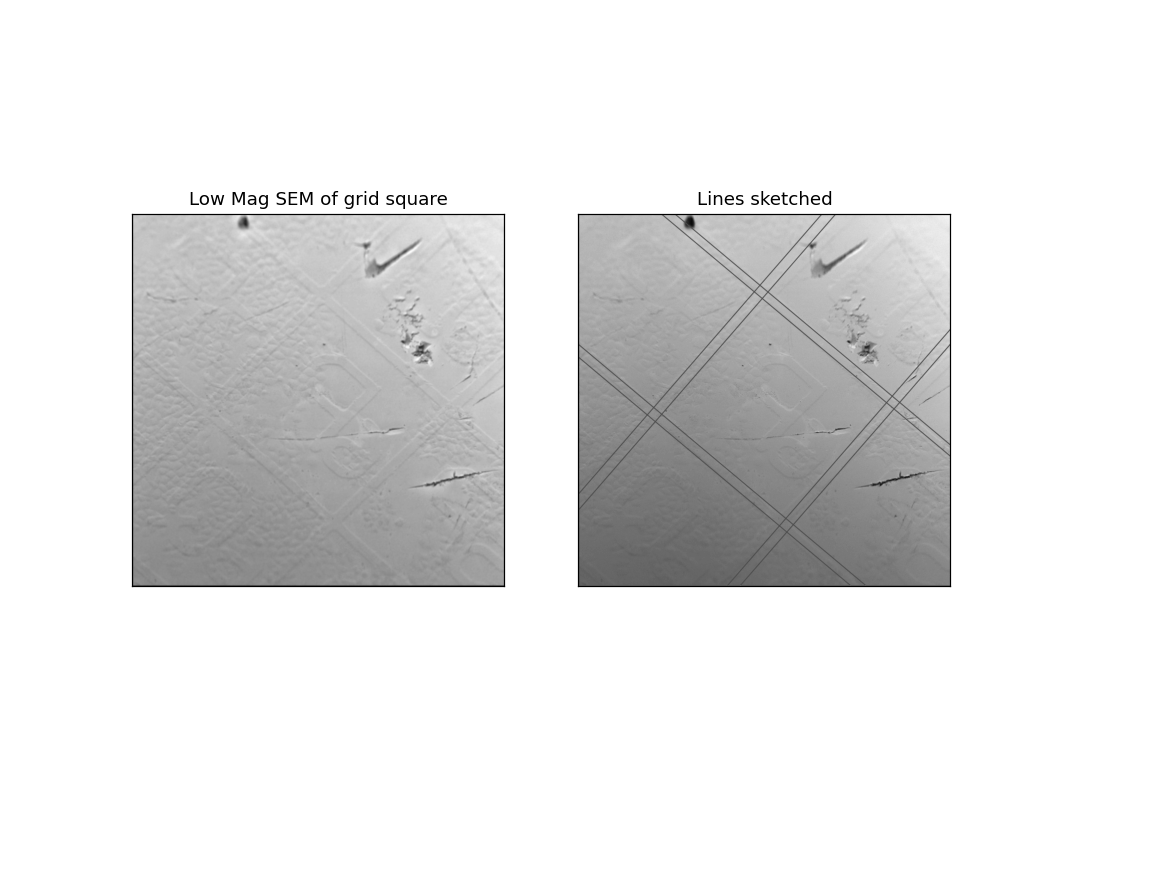

C:\Users\serra\Desktop\CLEMSite Paper\Latest\clemsite-notebooks\4_correlation_strategy_LM-SEM_global\utilities.py:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


In [2]:
%matplotlib notebook

import os
from os import path
import glob,csv,re
import sys
import cv2
import numpy as np
import utilities 

# 13_Nov_18
SCAN_13 = ".\\data\\13Jul18_1\\SCAN"
SCAN_13_p0 =  SCAN_13+"\\p0_20181031_164346"
lines =  SCAN_13_p0+"\\ld_31-Oct-2018-1643\lines_sketch.tif".replace("\\","/")
capture =  SCAN_13_p0+"\ld_31-Oct-2018-1643\prepro_p0_20181031_164346.tif".replace("\\","/")

im_capture = cv2.imread(capture,0)
im_lines_sketch = cv2.imread(lines,0)


utilities.show_images([im_capture,im_lines_sketch],titles= ["Low Mag SEM of grid square","Lines sketched"], shrink = 0.75)

The original detection of lines at this point can be only approximate. Edges are difficult to find at that magnification and lens effects distort the lines dramatically, so the grid crossing positions are not accurate.For this reason, an extra step moves to each squared position with a bigger magnification (350 $\mu$ m FOV), and by using the algorithms presented in the notebooks 1 and 2:

<IPython.core.display.Javascript object>


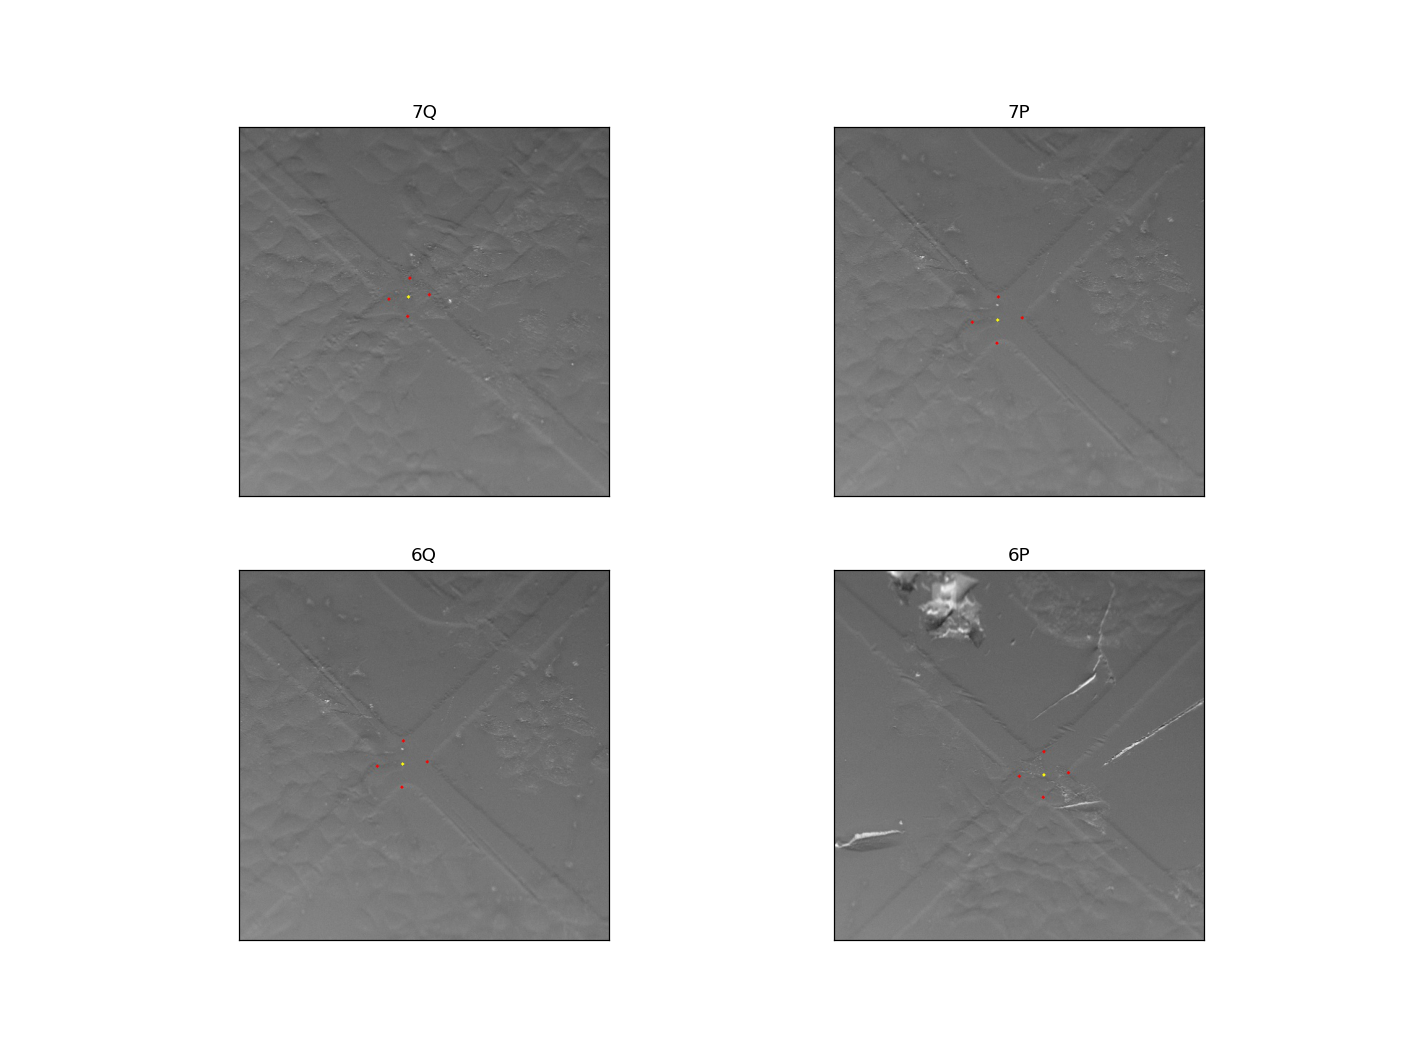

In [3]:
im0_f = SCAN_13_p0+"\\cross_det_ref_ref_0_7Q_201810311644344695\\ref_0_7Q_sketch.jpg"
im1_f = SCAN_13_p0+"\\cross_det_ref_ref_1_7P_201810311645323827\\ref_1_7P_sketch.jpg"
im2_f = SCAN_13_p0+"\\cross_det_ref_ref_2_6Q_201810311646300924\\ref_2_6Q_sketch.jpg"
im3_f = SCAN_13_p0+"\\cross_det_ref_ref_3_6P_201810311647288084\\ref_3_6P_sketch.jpg"

im0 = cv2.imread(im0_f,-1)
im1 = cv2.imread(im1_f,-1)
im2 = cv2.imread(im2_f,-1)
im3 = cv2.imread(im3_f,-1)
im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)


utilities.show_images([im0,im2,im2,im3],cols =2,titles= ["7Q","7P","6Q","6P"],shrink = 0.5)

Each position is calculated using image coordinates (pixels) and then translated to microscope stage coordinates (millimeters). The class Map from CLEMSite reads the MatTek grid specifications from the preferences file of CLEMSite, using the following values to validate that the detection of each crossing is in a good range:
    - DIST_SQ = 560 # um 
    - DIST_SPACE = 20 # um
    - DIST_GRID = 600 # 560+20+20 um 
    
The values are stored in the files determined by an alphanumerical character followed by __info.txt__ (e.g. 6P_info.txt). We can read those files as json:

In [4]:
import pandas as pd
import json

def readAllInfos(info_folder):
    data_positions = []
    list_files = glob.glob(info_folder+'\\??_info.txt')
    for el in list_files:
        #print(el)
        with open(el) as f:
            data_position = json.load(f)
            data_positions.append(data_position)
    df = pd.DataFrame(data_positions).T
    return df

df = readAllInfos(SCAN_13_p0)
df = df.transpose()

In [5]:
import csv
# The microscope stage coordinates have to be read from the individual folders inside the main folder and 
# replaced in Position X and Position Y (which are now the current center of the image)
for npath in glob.glob(os.path.join(SCAN_13_p0,'cross_det*')):
    file_p = glob.glob(os.path.join(npath,'ref_*_fpoints.csv'))[0]
    with open(file_p, newline='') as csvfile:
        valreader = csv.reader(csvfile, delimiter=',')
        for row in valreader:
            df.loc[df.tag==row[3],'posx'] = -float(row[0])
            df.loc[df.tag==row[3],'posy'] = -float(row[1])

            
df

DwellTime       FOV_X       FOV_Y PixelSize     WD     PositionX  \
0    8000.0  410.255249  410.255249   0.80128  0.005 -36275.351506   
1    8000.0  410.255249  410.255249   0.80128  0.005 -36629.335883   
2    8000.0  410.255249  410.255249   0.80128  0.005 -36712.871039   
3    8000.0  410.255249  410.255249   0.80128  0.005 -37066.874947   

      PositionY    PositionZ Width Height Beam              Aperture Detector  \
0 -63334.882867  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
1 -63741.640681  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
2 -62967.617241  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
3 -63374.375055  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   

    Contrast Brightness       posx       posy orientation tag letter_center  
0  19.764839  50.421902   36248.11  63356.516              6P                
1  19.764839  50.421902  36653.375  63751.258              6Q                
2  19.764839  50.421902   36686.43  62971.625              7P                
3  19.764839  50.421902  37084.504  63358.348              7Q


By visual inspection we can confirm that the yellow points, identified by our machine learning detector, are the crossing points. In our previous Jupyter notebook it was determined that the error of the algorithm in detection is $4.15+/-4\mu m$. We will validate that assumption and we double check using Fiji to find the center of the coordinates manually. Then we calculated the MSE respect the detected position, in pixels:  

<table>
  <tr>
    <th>Naming</th>
    <th>Position X,Y</th>
    <th>Position X,Y Human</th>
    <th>Difference pixels</th>
    <th>Difference micrometers</th>
  </tr>
  <tr>
    <td>7Q</td>
    <td>(232,236)</td>
    <td>(234,236)</td>
    <td>2</td>
    <td>1.6</td>
  </tr>
  <tr>
    <td>7P</td>
    <td>(289,261)</td>
    <td>(287,259)</td>
    <td>2.83</td>
    <td>2.26</td>
  </tr>
  <tr>
    <td>6P</td>
    <td>(290,283)</td>
    <td>(286,284)</td>
    <td>4.12</td>
    <td>3.3</td>
  </tr>
  <tr>
    <td>6Q</td>
    <td>(226,268)</td>
    <td>(229,263)</td>
    <td>5.83</td>
    <td>4.67</td>
  </tr>
</table>

The average error for the four corners detected is 2.96 +/- 1.16 micrometers, the error being in the expected range. 

After computing the image coordinates of the center, we translate those coordinates to stage coordinates. 

['6P', '6Q', '7P', '7Q']


<IPython.core.display.Javascript object>


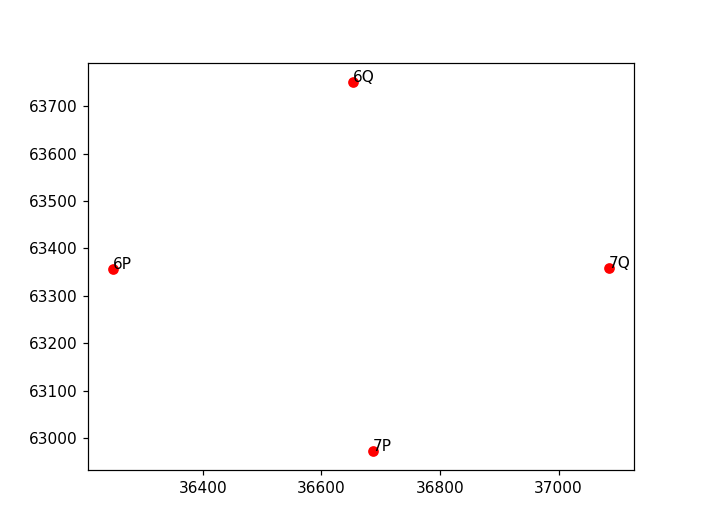

In [6]:
from matplotlib import pyplot as plt

df = df.transpose()
fpoints = np.array([[df[0].posx,df[0].posy],[df[1].posx,df[1].posy],[df[2].posx,df[2].posy],[df[3].posx,df[3].posy]], dtype = np.float32)
tags = [df[0].tag,df[1].tag,df[2].tag,df[3].tag]
print(tags)

fig, ax = plt.subplots()
ax.scatter(fpoints[:,0], fpoints[:,1], color='red')

for i, txt in enumerate(tags):
    ax.annotate(txt, (fpoints[i,0], fpoints[i,1]))

We are still missing an important parameter to complete our linear model: the orientation of the grid. It is important to find the relative orientation of the pattern, respect other patterns in the grid. There are two simple ways to find that orientation: 
  - If the user is clicking manually over the positions and introducing the identifier of each position (i.e, position (-36275.4,-63334.9) is 6P), it can be computed as the angle between the vectors formed using 3 adjacent positions.
  - Using a simple UI control, that straights up the pattern to the viewer, then the angle can be inferred internally.
  
  We know the orientation of this example is 43 degrees. With 4 points and their respective names and angle, the Map class will generate an inner map using the linear model.
  
 The corresponding python functions can be found in the files ```occupancy_map.py``` and ```ptp.py``` and are the same used in the software CLEMSite. 


In [7]:
from occupancy_map import *
my_map = Map(1)
my_map.generateGridMapCoordinates(-fpoints*0.001, tags, 43, type='EM')

<IPython.core.display.Javascript object>


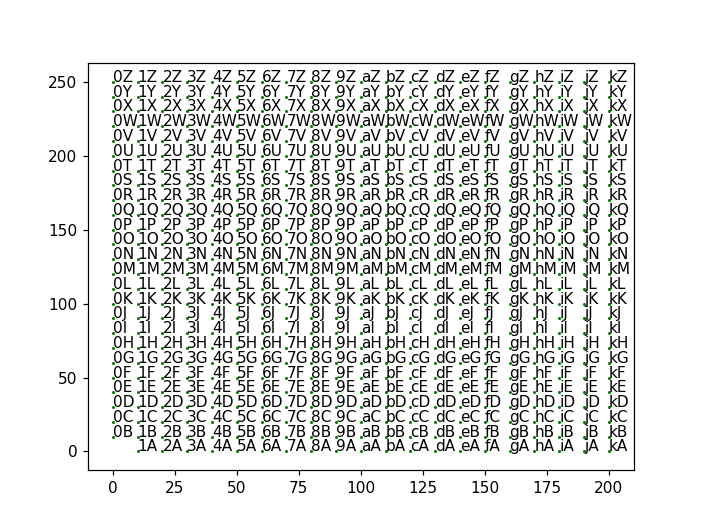

In [8]:
# let's plot the IDEAL squared map first
val_coords = np.array(list(my_map.map_coordinates_origin.values()))

fig, ax = plt.subplots()
ax.scatter(val_coords[:,0], val_coords[:,1], color='green',s=1)

for label,coord in my_map.map_coordinates_origin.items():
    ax.annotate(label, (coord[0], coord[1]))

<IPython.core.display.Javascript object>


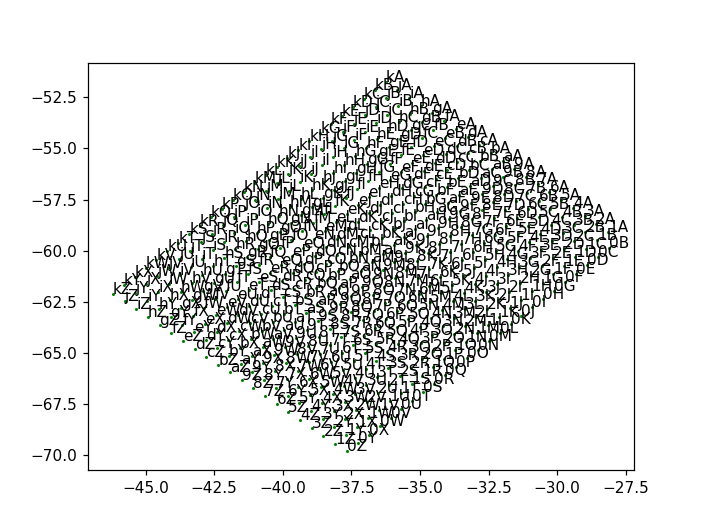

In [9]:
# let's plot such a map, now in microscope coordinates, rotated appropiately:
dest_coords = np.array(list(my_map.map_coordinates_destiny.values()))

fig, ax = plt.subplots()
ax.scatter(dest_coords[:,0], dest_coords[:,1], color='green',s=1)

for label,coord in my_map.map_coordinates_destiny.items():
    ax.annotate(label, (coord[0], coord[1]))

In [10]:
# Lets check for one random tag:
my_map.get4Neighbors('6O')

(['6O', '6N', '6P', '7O', '5O'],
 array([[ 60., 140.,   0.],
        [ 60., 130.,   0.],
        [ 60., 150.,   0.],
        [ 70., 140.,   0.],
        [ 50., 140.,   0.]], dtype=float32),
 array([[-35.850285, -62.94276 ,   0.      ],
        [-35.452457, -62.529007,   0.      ],
        [-36.24811 , -63.356518,   0.      ],
        [-36.2769  , -62.55693 ,   0.      ],
        [-35.423668, -63.328598,   0.      ]], dtype=float32))

## 2. Refining the basic model by using a SCAN

Once 4 points are collected and the map is created, we are ready to do a SCAN procedure (CLEM*Site* has an automatic routine for it). The scan controls the SEM stage moving to positions where crossings are predicted, in a sequential way. The first steps done to generate a global map of the grid is as it follows : 
 - Generate a list of estimated stage coordinates close to the origin (the first 4 points taken as reference for the model)
 - Move to the first adjacent position in the list and acquire an image at 350 $\mu$m. 
 - Classify the image using the terrain detector (notebook 3) and decide if it is good or out of limits. If bad, mark it in the map.
 - If good, use the GLD (generalized line detector) to find the center of the crossing and translate to stage coordinates.
 - Replace the stage coordinates in the original map by the new ones and mark them as "good"
 - Repeat until the list is completed.
 
  <img src="images/scan.png" width="600"/>
 
 
Sampling the full grid (546 points) is unnecessary. Usually around 80-100 positions (uniformly random sampled from the 546) are enough to map the full sample (the error of the global transformation converges). In SEM a SCAN takes around one hour for 100 positions (this could be optimized to half of the time if processing and acquisition were parallelized). Now, let's examine the results of one of these scans:

In [11]:
# Read all info values
ra = readAllInfos(SCAN_13)
ra = ra.transpose()
for npath in glob.glob(os.path.join(SCAN_13,'cross_det*')):
    file_p = glob.glob(os.path.join(npath,'ref_*_fpoints.csv'))[0]
    with open(file_p, newline='') as csvfile:
        valreader = csv.reader(csvfile, delimiter=',')
        for row in valreader:
            ra.loc[ra.tag==row[3],'posx'] = float(row[0])
            ra.loc[ra.tag==row[3],'posy'] = float(row[1])

ra.head(10)

DwellTime       FOV_X       FOV_Y PixelSize        WD     PositionX  \
0    4000.0  307.154449  307.154449  0.599911  0.005383 -30487.714764   
1    4000.0  307.154449  307.154449  0.599911   0.00536 -31692.206956   
2    4000.0  307.154449  307.154449  0.599911   0.00536 -32090.175708   
3    4000.0  307.154449  307.154449  0.599911  0.005383 -31728.769456   
4    4000.0  307.154449  307.154449  0.599911   0.00486 -34546.093687   
5    4000.0  307.154449  307.154449  0.599911   0.00486 -35340.644471   
6    4000.0  307.154449  307.154449  0.599911   0.00486  -35740.76166   
7    4000.0  307.154449  307.154449  0.599911   0.00536 -32164.374927   
8    4000.0  307.154449  307.154449  0.599911   0.00536 -32562.421804   
9    4000.0  307.154449  307.154449  0.599911  0.005209 -32958.007743   

      PositionY    PositionZ Width Height Beam              Aperture Detector  \
0 -61032.324264  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
1 -62203.964894  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
2 -62593.652395  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
3 -61421.972703  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
4 -64141.777402  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
5 -64914.218811  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
6 -65299.726625  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
7 -61030.527389  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
8 -61420.214891  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   
9  -61809.70708  41919.36846   512    512  SEM  1,5 kV | 700 pA [An]     SESI   

    Contrast Brightness       posx       posy orientation tag letter_center  
0  19.764839  50.421902 -30497.914 -61019.727              2F                
1  19.764839  50.421902 -31698.207 -62194.965              2I                
2  19.764839  50.421902 -32094.975 -62587.055              2J                
3  19.764839  50.421902 -31733.568 -61417.773              3H                
4  19.764839  50.421902 -34531.695  -64131.58              3O                
5  19.764839  50.421902 -35341.844  -64911.82              3Q                
6  19.764839  50.421902  -35744.36 -65299.727              3R                
7  19.764839  50.421902 -32167.375 -61031.727              4H                
8  19.764839  50.421902  -32570.22 -61425.016              4I                
9  19.764839  50.421902 -32968.207 -61806.707              4J

Checking all the available positions, we can calculate the area covered by this scan (53 entries). In the MatTeks used for our experiments, the area can vary between scans, but we restricted ourselves to an area between 50 and 100 $mm^2$. Potentially, the full dish could be scanned (1 $cm^2$).

In [12]:
# Let's compute how big is the area we are exploring
max_d_x = np.round(np.max(ra.posx)-np.min(ra.posx),2)*0.001
max_d_y = np.round(np.max(ra.posy)-np.min(ra.posy),2)*0.001
print("Maximum distance in x between points:"+str(np.round(max_d_x,3))+" mm.")
print("Maximum distance in y between points:"+str(np.round(max_d_y,3))+" mm.")
print("Area covered by the scan:"+str(np.round(max_d_x*max_d_y,3))+" mm2")

Maximum distance in x between points:8.291 mm.
Maximum distance in y between points:7.783 mm.
Area covered by the scan:64.532 mm2


And now, let's observe the difference between original model computed and scanned positions :

<IPython.core.display.Javascript object>


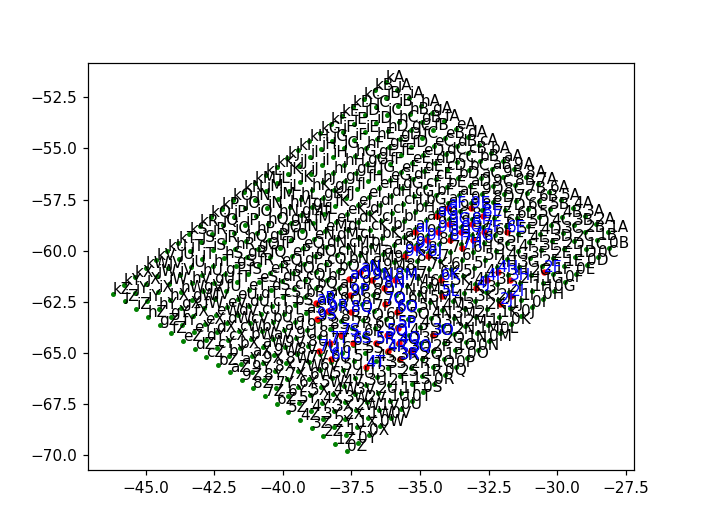

In [13]:
# let's plot such a map, now in microscope coordinates:
# Expected SEM coordinates
dest_coords = np.array(list(my_map.map_coordinates_destiny.values()))
# Found SEM coordinates
found_coords = np.array([el for el in zip(ra.posx,ra.posy)])*0.001
found_tags = ra.tag

fig, ax = plt.subplots()
ax.scatter(dest_coords[:,0], dest_coords[:,1], color='green',s=5)
ax.scatter(found_coords[:,0], found_coords[:,1], color='red',s=10)

for label,coord in my_map.map_coordinates_destiny.items():
    ax.annotate(label, (coord[0], coord[1]))

for i,fcoord in enumerate(found_coords):
    ax.annotate(found_tags[i], (fcoord[0], fcoord[1]), color='blue',annotation_clip=True)

In [14]:
dict_error = {}
found_tags = list(ra.tag)
for label,coord in my_map.map_coordinates_destiny.items():
    if label in found_tags:
        i = found_tags.index(label)
        dict_error[i]  = ((coord[0]-found_coords[i][0])**2 + (coord[1]-found_coords[i][1])**2)*1000

mse = np.mean(list(dict_error.values()))
rmsd = np.sqrt(mse)
rmsd_sd = np.std(list(dict_error.values()))
print("Total RMSD:"+str(rmsd)+"+/- 2STD "+str(rmsd_sd))

Total RMSD:4.751039675510408+/- 2STD 21.37397223234978


The root of the MSE (mean square error) in micrometers is good (less than 4 $\mu$m) but it has a big standard deviation: 21 micrometers!! That is problematic, because if our cell has an average diameter of 30 $\mu$m, we could miss the center of the target. If cells are confluent, we could even confuse the target cell.  

What is the reason of this error? The positions are taken from images with a field of view of 350 micrometers and totally independent. This could be due camera distortions, sample imperfections or tilting. In SEM we calculate the eucentric point, so then we can move in x and y even if the sample is tilted. However, when mounting the resin block into the stub, is very difficult to flatten it completely at the bottom. We are assuming a 2D plane on top of the sample, assumption that most of the times holds true, but it might be posssible that the precision of predictions could be improved using a 3D transformation. It is possible to adapt CLEM*Site* to 3D without much effort, an improvement, however, left for future versions of the software. 

In the following contour plot, we can observe that the error increases towards the right side, which confirms the suspicions of a tilting.

In [15]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(go.Contour(
        x = found_coords[:,0],
        y = found_coords[:,1],
        z = list(dict_error.values()),
               colorbar=dict(nticks=10, ticks='outside',
                         ticklen=5, tickwidth=1,
                         showticklabels=True,
                         tickangle=0, tickfont_size=12),
    contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 12,
                color = 'white',
            ))))

fig.show()

## 3. The VirtualGrid Map class in CLEMSite 

Internally, CLEMSite does not use just one simple affine transformation. It uses a system of occupancy maps to track the correlation between positions, where each position is in the map is assigned to a status. Let's look at the Grid Map class.


In [16]:
from virtualGridMap import *
from virtualMapManager import *
from microadapterAtlas import *
from numpy.linalg import matrix_rank,qr
from scipy.linalg import orth
import logging
import re
import os
import glob,csv


This is an instantiation example of the CLEMSite MapManager class (an emulation of what happens when software is running).

In [17]:
logger = logging.getLogger('MyLogger')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler(sys.stdout)
dformat = logging.Formatter("%(asctime)s - %(message)s")
ch.setFormatter(dformat)
logger.addHandler(ch)
# Server that connects to CLEMSiteServer. We don't need it but it is required
# by the VirtualMapManagerSEM class, so we will use an emulator
msc_server = MicroAdapterAtlas()  

msc_server.setLogger(logger)
vMapManager = VirtualMapManagerSEM(logger, msc_server)

# We add a canvas-SEM map type. This will create an inner virtual Grid Map
vMapManager.addMap("Canvas_SEM")

Internally, a class VirtualMapManager is declared. That class contains a Virtual Grid Map class. A Virtual Grid Map class stores a correspondence between coordinates of two different maps. For example, Light Microscopy stage coordinates and SEM stage coordinates, using the tuple (Identifier, Position_LM, Position_SEM).  

Three types of maps can exist inside the VirtualMapManager :
- Canvas-LM, for creating a correspondence between an ideal schematic of a map and light microscope stage coordinates. To picture this, imagine the first list as pencil marks on a paper map and the second list storing GPS coordinates of that marks. 
- Canvas-SEM, same between ideal schematic and SEM stage positions. 
- LM-SEM, correspondences of stage coordinates between LM and SEM. 

<img src="images/maps.png" width="800"/>

The Canvas-SEM can be used to display the map in a UI. If the user clicks on the display map, the corresponding SEM stage coordinate can be computed and then used as a navigation system for the SEM. The same for the Canvas-LM, if we were connecting to light microscope. For the SEM microscope only the Canvas-SEM and LM-SEM maps are needed. 

The first map is usually called the **origin map** and the second the **destiny map**, but be aware that these are arbitrary definitions (origin or destiny are arbitrary).


### Positions status inside a map

Each position inside a Virtual Grid Map class can be catalogued in one of this 4 types:

<table>
  <tr>
    <th>Type of Position</th>
    <th>Origin Map</th>
    <th>Destiny Map</th>
    <th style="text-align:left">Description</th>
  </tr>
  <tr>
    <td style="text-align:left">CALIBRATED (Scanned Landmark)</td>
    <td style="width:100px">Value defined</td>
    <td style="width:100px">Value defined</td>
    <td style="text-align:left">Position that is known in both maps and used for registration purposes.</td>
  </tr>
   <tr>
    <td style="text-align:left">NON_CALIBRATED (Non Scanned Landmark)</td>
    <td>Value defined</td>
    <td>Not available</td>
    <td style="text-align:left">Position that has not been found yet in the destiny map, e.g. the LM stage coordinates are available but the SEM are still unknown.</td>
  </tr>
   <tr>
    <td style="text-align:left">ACQUIRED (-)</td>
    <td>Not Available</td>
    <td>Value defined</td>
    <td style="text-align:left">Position that has no correspondence in the origin map. E.g. Moving around in SEM we found a position interesting to us, so we decided to save its stage coordinates, but the stage coordinates of the light microscopy are unknown.</td>
    </tr>
    <tr>
    <td style="text-align:left">TARGET (Organelle position)</td>
    <td>Value defined</td>
    <td>Not available</td>
    <td style="text-align:left">Position that is known in the origin map, but has to be predicted in the destiny map. E.g. the centroid of the cell, which is known in stage coordinates of the light microscope, and we want to find the equivalent coordinates in the SEM.</td>
    </tr>
</table>
    
   In addition to that, each position can be in a state blocked or unblocked. It is blocked if it is outside limits or from a damaged region, or if we do not want to use that position as reference for a local affine transformation between LM and SEM.
  The following picture shows a summary of how the categories:
  <img src="images/mappingCLEMSite.PNG" width="800"/>

To compute our global transformation, after creating the manager class and maps classes, we can add the set of points we obtained before:

In [18]:
# Use the occupancy map to get the equivalent Canvas (fake coordinates)
origin_coords_Canvas = np.array(list(my_map.getCoordinatesGrid(found_tags)))

destiny_coords_SEM = np.pad(found_coords,pad_width=(0,1))*0.001 # Pass to micrometers

In [19]:
# Now add the points, 
vMapManager.addSetPoints(origin_coords_Canvas, destiny_coords_SEM, found_tags, "Canvas_SEM",PointType.calibrated,updateModel=True)

2021-04-18 12:00:02,002 - From Canvas_SEM:Updating transform with 53 reference points


To compute a global transformation (with all 53 points) and evaluate its error, we call the function updateErrorByCV, which does the following:
   - Gets one position, and takes ALL neighbors.
   - Compute an affine transformation with those 50 closest neighbors and predict the position of itself.
   - Compute the RMSE between the predicted and the real position of the excluded point.
   - If the error distance between predicted and real is bigger than the tolerance (30 $\mu m$ per position), the point is put in a blocked list and removed from the dataset.
   - Repeat for the rest of the positions (52).
   - If a position has been rejected, we repeat the procedure and recalculate the global transformation. By doing this we are computing more accurate transformations.
   - The procedure iterates until there is a convergence of the average error, i.e., positions cannot be rejected anymore.
  
   This procedure is a simplified version of [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus).

In [20]:
# We discard any point that has an error bigger than 30 um.
blocked_list, blocked_errors, good_list,error_list = vMapManager.updateErrorByCV("Canvas_SEM", num_neighs = 52, tolerance = 30)

2021-04-18 12:00:02,698 - Finding bad apples in predictions!
2021-04-18 12:00:02,699 - # Iteration 0
2021-04-18 12:00:02,805 - Position :2F with values [-0.03049791 -0.06101973  0.        ]. Error found to be: 1.0134949661733117e-05
2021-04-18 12:00:02,899 - Position :2I with values [-0.03169821 -0.06219497  0.        ]. Error found to be: 2.9851176464035234e-07
2021-04-18 12:00:02,946 - Position :2J with values [-0.03209497 -0.06258705  0.        ]. Error found to be: 5.2094956117798574e-06
2021-04-18 12:00:03,027 - Position :3H with values [-0.03173357 -0.06141777  0.        ]. Error found to be: 2.391778480159701e-06
2021-04-18 12:00:03,103 - Position :3O with values [-0.03453169 -0.06413158  0.        ]. Error found to be: 9.495796803093981e-06
2021-04-18 12:00:03,104 - # Iteration 5
2021-04-18 12:00:03,203 - Position :3Q with values [-0.03534184 -0.06491182  0.        ]. Error found to be: 5.744572717958363e-06
2021-04-18 12:00:03,255 - Position :3R with values [-0.03574436 -0.065

If we keep the global transformation from this collection of points, we obtain:
```
Average error sample 6.44 +/-4.34 um
```
Note: All stage coordinates are converted to meters, thus, ignore the 1e-6 at the end of the result. The error is set in micrometers.

##### Error with Local transformation (theoretical)

Let's try now if we reduce the number of neighbors in the transformation to 8.

In [21]:
# We discard any point that has an error bigger than 30 um.
blocked_list, blocked_errors, good_list,error_list = vMapManager.updateErrorByCV("Canvas_SEM", num_neighs = 8, tolerance = 30)

2021-04-18 12:00:07,245 - Finding bad apples in predictions!
2021-04-18 12:00:07,250 - # Iteration 0
2021-04-18 12:00:07,266 - Position :2F with values [-0.03049791 -0.06101973  0.        ]. Error found to be: 2.7359392333892174e-06
2021-04-18 12:00:07,280 - Position :2I with values [-0.03169821 -0.06219497  0.        ]. Error found to be: 2.422495981591055e-06
2021-04-18 12:00:07,298 - Position :2J with values [-0.03209497 -0.06258705  0.        ]. Error found to be: 4.155242095293943e-06
2021-04-18 12:00:07,315 - Position :3H with values [-0.03173357 -0.06141777  0.        ]. Error found to be: 2.3719569526292617e-06
2021-04-18 12:00:07,336 - Position :3O with values [-0.03453169 -0.06413158  0.        ]. Error found to be: 4.741578777611721e-06
2021-04-18 12:00:07,337 - # Iteration 5
2021-04-18 12:00:07,350 - Position :3Q with values [-0.03534184 -0.06491182  0.        ]. Error found to be: 5.617496753984597e-06
2021-04-18 12:00:07,362 - Position :3R with values [-0.03574436 -0.0652

We managed to reduce the error to 4.529 +/- 3.4 um.

## 4. Average error of 4 SCANs 

Here we will repeat the same strategy with 3 more SCANS. The correspondence with the experiments in the paper are as it follows:

|  Sample in this notebook    |  Equivalent sample in data folders   |      
| :--: | ---- | 
|  13 Jul Dataset 1   |  Sample1_Spots    |     
|  14 Nov Dataset 2   |  Sample1_COPB1    |      
|  19 Nov Dataset 3   |  Sample2_Spots    |      
|  21 Nov Dataset 4   |  Sample2_COPB1    |      



In [22]:
def read_position_from_files(root_dir):
    # Read all info values
    dfn = readAllInfos(root_dir)
    dfn = dfn.transpose()
    for npath in glob.glob(os.path.join(root_dir,'cross_det*')):
        file_p = glob.glob(os.path.join(npath,'ref_*_fpoints.csv'))[0]
        with open(file_p, newline='') as csvfile:
            valreader = csv.reader(csvfile, delimiter=',')
            for row in valreader:
                dfn.loc[dfn.tag==row[3],'posx'] = float(row[0])
                dfn.loc[dfn.tag==row[3],'posy'] = float(row[1])
    return dfn

#### Dataset 2

['1H', '1I', '2H', '2I']


<IPython.core.display.Javascript object>


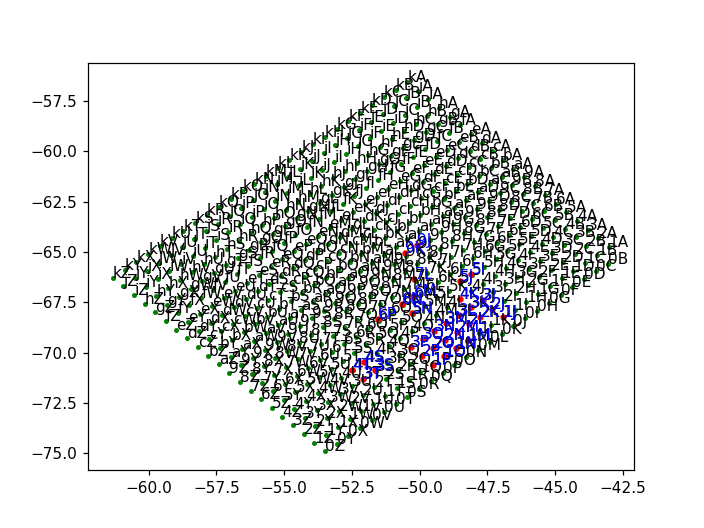

In [23]:
SCAN_14 = ".\\data\\14Nov18\\SCAN"
SCAN_14_p0 = ".\\data\\14Nov18\\SCAN\\p0_20190313_171704"

######### 1. 4 positions model ############
ra2_p0 = read_position_from_files(SCAN_14_p0)

df = ra2_p0.transpose()
fpoints = np.array([[df[0].posx,df[0].posy],[df[1].posx,df[1].posy],[df[2].posx,df[2].posy],[df[3].posx,df[3].posy]], dtype = np.float32)
tags = [df[0].tag,df[1].tag,df[2].tag,df[3].tag]
print(tags)

my_map_14N= Map(1)
my_map_14N.generateGridMapCoordinates(-fpoints*0.001, tags, 48, type='EM')

############# 2.  Read the SCAN and the positions for each crossing #########

ra2 = read_position_from_files(SCAN_14)
# let's plot such a map, now in microscope coordinates:
dest_coords = np.array(list(my_map_14N.map_coordinates_destiny.values()))
found_coords = np.array([el for el in zip(-ra2.posx,-ra2.posy)])*0.001
found_tags = ra2.tag

# Plot them

fig, ax = plt.subplots()
ax.scatter(dest_coords[:,0], dest_coords[:,1], color='green',s=5)
ax.scatter(found_coords[:,0], found_coords[:,1], color='red',s=10)

for label,coord in my_map_14N.map_coordinates_destiny.items():
    ax.annotate(label, (coord[0], coord[1]))

for i,fcoord in enumerate(found_coords):
    ax.annotate(found_tags[i], (fcoord[0], fcoord[1]), color='blue',annotation_clip=True)

In [24]:
# Area covered
max_d_x = np.round(np.max(ra2.posx)-np.min(ra2.posx),2)*0.001
max_d_y = np.round(np.max(ra2.posy)-np.min(ra2.posy),2)*0.001
print("Maximum distance in x between points:"+str(np.round(max_d_x,3))+" mm.")
print("Maximum distance in y between points:"+str(np.round(max_d_y,3))+" mm.")
print("Area covered by the scan:"+str(np.round(max_d_x*max_d_y,3))+" mm2")

Maximum distance in x between points:5.553 mm.
Maximum distance in y between points:6.64 mm.
Area covered by the scan:36.875 mm2


In [25]:
# Error plot and average global error
vMapManager2 = VirtualMapManagerSEM(logger, msc_server)

# We add a canvas-SEM map type. This will create an inner virtual Grid Map
vMapManager2.addMap("Canvas_SEM")

In [26]:
# Error from sampled plots
# Use the occupancy map to get the equivalent Canvas (fake coordinates)
origin_coords_Canvas = np.array(list(my_map_14N.getCoordinatesGrid(found_tags)))
destiny_coords_SEM = np.pad(found_coords,pad_width=(0,1))*0.001 # Pass to micrometers
# Now add the points, 
vMapManager2.addSetPoints(origin_coords_Canvas, destiny_coords_SEM, found_tags, "Canvas_SEM",PointType.calibrated,updateModel=True)

2021-04-18 12:00:09,713 - From Canvas_SEM:Updating transform with 33 reference points


In [27]:
# We discard any point that has an error bigger than 30 um.
blocked_list, blocked_errors, good_list,error_list = vMapManager2.updateErrorByCV("Canvas_SEM", num_neighs = 32, tolerance = 30)

2021-04-18 12:00:10,180 - Finding bad apples in predictions!
2021-04-18 12:00:10,181 - # Iteration 0
2021-04-18 12:00:10,244 - Position :1J with values [-0.0469325  -0.06823922  0.        ]. Error found to be: 3.076939538004808e-05
2021-04-18 12:00:10,373 - Position :1M with values [-0.04820783 -0.06939666  0.        ]. Error found to be: 3.109242607024498e-05
2021-04-18 12:00:10,408 - Position :1N with values [-0.04864902 -0.06979219  0.        ]. Error found to be: 2.5962033760151826e-05
2021-04-18 12:00:10,439 - Position :1O with values [-0.04908894 -0.0701916   0.        ]. Error found to be: 1.7568154362379573e-05
2021-04-18 12:00:10,484 - Position :1P with values [-0.04952811 -0.07059228  0.        ]. Error found to be: 8.063006134761963e-06
2021-04-18 12:00:10,485 - # Iteration 5
2021-04-18 12:00:10,519 - Position :2J with values [-0.04732754 -0.06782084  0.        ]. Error found to be: 3.136215309496038e-05
2021-04-18 12:00:10,592 - Position :2K with values [-0.04776576 -0.0682

In [28]:
# Local with 8 neighbors.
blocked_list, blocked_errors, good_list,error_list = vMapManager2.updateErrorByCV("Canvas_SEM", num_neighs = 8, tolerance = 30)

2021-04-18 12:00:11,973 - Finding bad apples in predictions!
2021-04-18 12:00:11,975 - # Iteration 0
2021-04-18 12:00:12,003 - Position :1J with values [-0.0469325  -0.06823922  0.        ]. Error found to be: 2.4976816348498687e-05
2021-04-18 12:00:12,017 - Position :1M with values [-0.04820783 -0.06939666  0.        ]. Error found to be: 2.070271148113534e-05
2021-04-18 12:00:12,027 - Position :1N with values [-0.04864902 -0.06979219  0.        ]. Error found to be: 7.5785928856930695e-06
2021-04-18 12:00:12,037 - Position :1O with values [-0.04908894 -0.0701916   0.        ]. Error found to be: 1.2031476899210247e-06
2021-04-18 12:00:12,047 - Position :1P with values [-0.04952811 -0.07059228  0.        ]. Error found to be: 6.893635145388544e-06
2021-04-18 12:00:12,048 - # Iteration 5
2021-04-18 12:00:12,058 - Position :2J with values [-0.04732754 -0.06782084  0.        ]. Error found to be: 1.827755113481544e-05
2021-04-18 12:00:12,068 - Position :2K with values [-0.04776576 -0.068

#### Dataset 3

['5K', '5L', '6K', '6L']


<IPython.core.display.Javascript object>


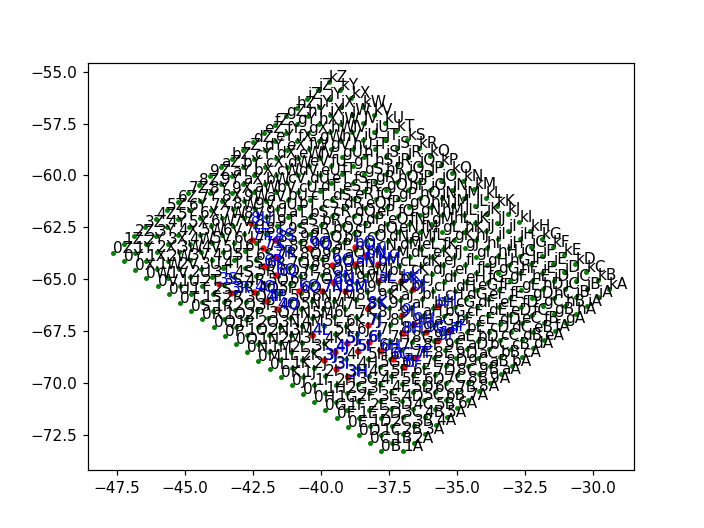

In [29]:
SCAN_19 = ".\\data\\19Nov18\\SCAN"
SCAN_19_p0 = ".\\data\\19Nov18\\SCAN\\p0_20190418_185429"

######### 1. 4 positions model ############
ra3_p0 = read_position_from_files(SCAN_19_p0)

df = ra3_p0.transpose()
fpoints = np.array([[df[0].posx,df[0].posy],[df[1].posx,df[1].posy],[df[2].posx,df[2].posy],[df[3].posx,df[3].posy]], dtype = np.float32)
tags = [df[0].tag,df[1].tag,df[2].tag,df[3].tag]
print(tags)

my_map_19N= Map(1)
my_map_19N.generateGridMapCoordinates(-fpoints*0.001, tags, 134, type='EM')

############# 2.  Read the SCAN and the positions for each crossing #########

ra3 = read_position_from_files(SCAN_19)
# let's plot such a map, now in microscope coordinates:
dest_coords = np.array(list(my_map_19N.map_coordinates_destiny.values()))
found_coords = np.array([el for el in zip(-ra3.posx,-ra3.posy)])*0.001
found_tags = ra3.tag

# Plot them

fig, ax = plt.subplots()
ax.scatter(dest_coords[:,0], dest_coords[:,1], color='green',s=5)
ax.scatter(found_coords[:,0], found_coords[:,1], color='red',s=10)

for label,coord in my_map_19N.map_coordinates_destiny.items():
    ax.annotate(label, (coord[0], coord[1]))

for i,fcoord in enumerate(found_coords):
    ax.annotate(found_tags[i], (fcoord[0], fcoord[1]), color='blue',annotation_clip=True)


In [30]:
# Area covered
max_d_x = np.round(np.max(ra3.posx)-np.min(ra3.posx),2)*0.001
max_d_y = np.round(np.max(ra3.posy)-np.min(ra3.posy),2)*0.001
print("Maximum distance in x between points:"+str(np.round(max_d_x,3))+" mm.")
print("Maximum distance in y between points:"+str(np.round(max_d_y,3))+" mm.")
print("Area covered by the scan:"+str(np.round(max_d_x*max_d_y,3))+" mm2")

Maximum distance in x between points:8.437 mm.
Maximum distance in y between points:7.453 mm.
Area covered by the scan:62.88 mm2


In [31]:
# Error plot and average global error
vMapManager3 = VirtualMapManagerSEM(logger, msc_server)

# We add a canvas-SEM map type. This will create an inner virtual Grid Map
vMapManager3.addMap("Canvas_SEM")

In [32]:
# Error from sampled plots
# Use the occupancy map to get the equivalent Canvas (fake coordinates)
origin_coords_Canvas = np.array(list(my_map_19N.getCoordinatesGrid(found_tags)))
destiny_coords_SEM = np.pad(found_coords,pad_width=(0,1))*0.001 # Pass to micrometers
# Now add the points, 
vMapManager3.addSetPoints(origin_coords_Canvas, destiny_coords_SEM, found_tags, "Canvas_SEM",PointType.calibrated,updateModel=True)

2021-04-18 12:00:14,118 - From Canvas_SEM:Updating transform with 46 reference points


In [33]:
blocked_list, blocked_errors, good_list,error_list = vMapManager3.updateErrorByCV("Canvas_SEM", num_neighs = 45, tolerance = 30)

2021-04-18 12:00:14,680 - Finding bad apples in predictions!
2021-04-18 12:00:14,680 - # Iteration 0
2021-04-18 12:00:14,825 - Position :3H with values [-0.03901765 -0.06972955  0.        ]. Error found to be: 1.1084015568485484e-05
2021-04-18 12:00:14,871 - Position :3I with values [-0.039445   -0.06932994  0.        ]. Error found to be: 2.5365507099195383e-06
2021-04-18 12:00:14,939 - Position :3J with values [-0.03987531 -0.06892259  0.        ]. Error found to be: 3.554551767592784e-06
2021-04-18 12:00:15,002 - Position :3R with values [-0.04330643 -0.06565504  0.        ]. Error found to be: 1.0203700185229536e-05
2021-04-18 12:00:15,072 - Position :3S with values [-0.04373791 -0.06524514  0.        ]. Error found to be: 1.3496804058377165e-05
2021-04-18 12:00:15,074 - # Iteration 5
2021-04-18 12:00:15,175 - Position :4J with values [-0.03946631 -0.06849869  0.        ]. Error found to be: 6.167699211800937e-06
2021-04-18 12:00:15,216 - Position :4L with values [-0.04032037 -0.06

In [34]:
# Now local with 8 neighbors
blocked_list, blocked_errors, good_list,error_list = vMapManager3.updateErrorByCV("Canvas_SEM", num_neighs = 8, tolerance = 30)

2021-04-18 12:00:18,408 - Finding bad apples in predictions!
2021-04-18 12:00:18,409 - # Iteration 0
2021-04-18 12:00:18,420 - Position :3H with values [-0.03901765 -0.06972955  0.        ]. Error found to be: 2.573072833911283e-06
2021-04-18 12:00:18,430 - Position :3I with values [-0.039445   -0.06932994  0.        ]. Error found to be: 3.753460532607278e-06
2021-04-18 12:00:18,440 - Position :3J with values [-0.03987531 -0.06892259  0.        ]. Error found to be: 2.921397253885516e-06
2021-04-18 12:00:18,450 - Position :3R with values [-0.04330643 -0.06565504  0.        ]. Error found to be: 2.3790375962562393e-06
2021-04-18 12:00:18,461 - Position :3S with values [-0.04373791 -0.06524514  0.        ]. Error found to be: 1.6902353081604815e-06
2021-04-18 12:00:18,461 - # Iteration 5
2021-04-18 12:00:18,472 - Position :4J with values [-0.03946631 -0.06849869  0.        ]. Error found to be: 2.2018105028109858e-06
2021-04-18 12:00:18,506 - Position :4L with values [-0.04032037 -0.067

### Dataset 4

In [35]:
SCAN_21 = ".\\data\\21Nov18\\SCAN"
SCAN_21_p0 = ".\\data\\21Nov18\\SCAN\\p0_20190205_101409"

######### 1. 4 positions model ############
ra4_p0 = read_position_from_files(SCAN_21_p0)

df = ra4_p0.transpose()
fpoints = np.array([[df[0].posx,df[0].posy],[df[1].posx,df[1].posy],[df[2].posx,df[2].posy],[df[3].posx,df[3].posy]], dtype = np.float32)
tags = [df[0].tag,df[1].tag,df[2].tag,df[3].tag]
print(tags)

my_map_21N= Map(1)
my_map_21N.generateGridMapCoordinates(-fpoints*0.001, tags, 227, type='EM')
############# 2.  Read the SCAN and the positions for each crossing #########

ra4 = read_position_from_files(SCAN_21)
# let's plot such a map, now in microscope coordinates:
dest_coords = np.array(list(my_map_21N.map_coordinates_destiny.values()))
found_coords = np.array([el for el in zip(-ra4.posx,-ra4.posy)])*0.001
found_tags = ra4.tag

# Plot them

fig, ax = plt.subplots()
ax.scatter(dest_coords[:,0], dest_coords[:,1], color='green',s=5)
ax.scatter(found_coords[:,0], found_coords[:,1], color='red',s=10)

for label,coord in my_map_21N.map_coordinates_destiny.items():
    ax.annotate(label, (coord[0], coord[1]))

for i,fcoord in enumerate(found_coords):
    ax.annotate(found_tags[i], (fcoord[0], fcoord[1]), color='blue',annotation_clip=True)

['7Q', '7R', '8Q', '8R']


<IPython.core.display.Javascript object>

In [36]:
# Area covered
max_d_x = np.round(np.max(ra4.posx)-np.min(ra4.posx),2)*0.001
max_d_y = np.round(np.max(ra4.posy)-np.min(ra4.posy),2)*0.001
print("Maximum distance in x between points:"+str(np.round(max_d_x,3))+" mm.")
print("Maximum distance in y between points:"+str(np.round(max_d_y,3))+" mm.")
print("Area covered by the scan:"+str(np.round(max_d_x*max_d_y,3))+" mm2")


Maximum distance in x between points:6.293 mm.
Maximum distance in y between points:6.58 mm.
Area covered by the scan:41.405 mm2


In [37]:
# Error plot and average global error
vMapManager4 = VirtualMapManagerSEM(logger, msc_server)

# We add a canvas-SEM map type. This will create an inner virtual Grid Map
vMapManager4.addMap("Canvas_SEM")

# Error from sampled plots
# Use the occupancy map to get the equivalent Canvas (fake coordinates)
origin_coords_Canvas = np.array(list(my_map_21N.getCoordinatesGrid(found_tags)))
destiny_coords_SEM = np.pad(found_coords,pad_width=(0,1))*0.001 # Pass to micrometers
# Now add the points, 
vMapManager4.addSetPoints(origin_coords_Canvas, destiny_coords_SEM, found_tags, "Canvas_SEM",PointType.calibrated,updateModel=True)


2021-04-18 12:00:20,961 - From Canvas_SEM:Updating transform with 47 reference points


In [38]:
blocked_list, blocked_errors, good_list,error_list = vMapManager4.updateErrorByCV("Canvas_SEM", num_neighs = 46, tolerance = 30)

2021-04-18 12:00:21,647 - Finding bad apples in predictions!
2021-04-18 12:00:21,648 - # Iteration 0
2021-04-18 12:00:21,690 - Position :3K with values [0.03931348 0.06793061 0.        ]. Error found to be: 1.204463933390798e-05
2021-04-18 12:00:21,758 - Position :3M with values [0.04014971 0.06875092 0.        ]. Error found to be: 3.149617259623483e-05
2021-04-18 12:00:21,823 - Position :3N with values [0.04056605 0.06915975 0.        ]. Error found to be: 4.494171662372537e-05
2021-04-18 12:00:21,949 - Position :4G with values [0.03806708 0.06587256 0.        ]. Error found to be: 1.8072321836370975e-05
2021-04-18 12:00:21,991 - Position :4J with values [0.0393196  0.06712764 0.        ]. Error found to be: 1.213984978676308e-05
2021-04-18 12:00:21,991 - # Iteration 5
2021-04-18 12:00:22,065 - Position :4K with values [0.0397     0.06756584 0.        ]. Error found to be: 5.666692595696077e-05
2021-04-18 12:00:22,131 - Position :4N with values [0.04100782 0.06875899 0.        ]. Err

In [39]:
# With 8 neighbors
blocked_list, blocked_errors, good_list,error_list = vMapManager4.updateErrorByCV("Canvas_SEM", num_neighs = 8, tolerance = 30)

2021-04-18 12:00:25,151 - Finding bad apples in predictions!
2021-04-18 12:00:25,151 - # Iteration 0
2021-04-18 12:00:25,170 - Position :3K with values [0.03931348 0.06793061 0.        ]. Error found to be: 2.7757638235925697e-05
2021-04-18 12:00:25,181 - Position :3M with values [0.04014971 0.06875092 0.        ]. Error found to be: 9.929837688105181e-06
2021-04-18 12:00:25,190 - Position :3N with values [0.04056605 0.06915975 0.        ]. Error found to be: 2.5186807761201635e-05
2021-04-18 12:00:25,201 - Position :4G with values [0.03806708 0.06587256 0.        ]. Error found to be: 2.6449666620464996e-05
2021-04-18 12:00:25,210 - Position :4J with values [0.0393196  0.06712764 0.        ]. Error found to be: 7.099860795278801e-06
2021-04-18 12:00:25,211 - # Iteration 5
2021-04-18 12:00:25,221 - Position :4K with values [0.0397     0.06756584 0.        ]. Error found to be: 5.054591383668594e-05
2021-04-18 12:00:25,236 - Position :4N with values [0.04100782 0.06875899 0.        ]. E

Average of data: 
   
<table>
  <tr>
    <th>Sample</th>
    <th>Value</th>
      <th>Number of positions obtained in scan</th>
  </tr>
  <tr>
    <td style="text-align:left">13 Jul - S1-Spots</td>
    <td style="width:100px">6.44 +/-4.3</td>
    <td style="width:100px">53</td>
  </tr>
  <tr>
    <td style="text-align:left">19 Nov - S2-Spots</td>
    <td style="width:100px">9.622 +/-5.1</td>
    <td style="width:100px">46</td>
  </tr>
  <tr>
    <td style="text-align:left">14 Nov - S1-COPB1</td>
    <td style="width:100px">18.76 +/-11.5</td>
    <td style="width:100px">33</td>
  </tr>

  <tr>
    <td style="text-align:left">21 Nov - S2-COPB1</td>
    <td style="width:100px">20.56 +/-13.54</td>
    <td style="width:100px">47</td>
  </tr>
  <tr>
    <td style="text-align:left">Average and SD</td>
    <td style="width:100px">13.21 +/-6.16</td>
  </tr>
    </table>
    
   Average and SD for the whole group was calculated as the weighted mean and variance for the 4 samples. To calculate average and sd, we assume a normal distributions of the RMSE.
   
  __Important: even if we assume same conditions for all samples, there are multiple factors which can make this error change: quality of the surface sample after removal of the glass, coating, dirt speckles, deformations of the resin, tilting... For all the experiments, and using a global affine transformation, the magnitude of error was always around 20 micrometers in the worst case.__
  